Fitting ACTUAL in-flight mid-IR data to prelaunch predictions.  Sept 2022, using latest reductions (Sept 11) from Maca of MIRI team.  jrigby, 29 Sept 2022

In [333]:
import jrr
from os.path import basename
import numpy as np
from astropy import constants
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.time import Time
from astropy import constants
from astropy import units
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.backends.backend_pdf import PdfPages
from cycler import cycler
import pandas
import glob
matplotlib.rcParams.update({'font.size': 22})

In [334]:
vv = "3.0"
Title =  "Title:    JWST thermal background spectrum to match commisioning results\n"
Author = "Author:   Jane Rigby (Jane.Rigby@nasa.gov)\n"
Date =   "Date:     15 Oct 2022\n"
Version = "Version:  " + vv + "\n"
Format = "Format:   comma separated variables (csv)\n"
Distribution = "Distribution:  unlimited (see STI approval in attached NASA form 1675B.)\n"
Columns = "Columns: wavelength (micron) and equivalent sky radiance (MJy/SR)\n"
Pedigree  = "Pedigree: This is the predicted self-emission thermal background spectrum for JWST,\n"
Pedigree += "for use in planning observations.  At long wavelengths, this self-emission (from\n"
Pedigree += "the observatory itself) dominates over astrophysical backgrounds.  This spectrum\n"
Pedigree += "was built by summing approximately 20 blackbody curves representing\n"
Pedigree += "major components of the observatory.  This file was generated by\n"
Pedigree += "Jane Rigby's Jupyter python notebook Fitting Maca's MIRI thermal IR results_v3.ipynb.\n"
Pedigree += "This is a simple modification to the pre-launch model to match the median backgrounds\n"
Pedigree += "observed in JWST commissioning data from the hot and cold thermal stability tests.\n"
Pedigree += "MIRI data were reduced by Maca Garcia-Marin, using flux calib as of 11 Oct 2022.\n"
Pedigree += "The model inputs are predicted irradiances from Paul Lightsey's 2019.12.03_MIR_summary.xlsx, \n"
Pedigree += "dated Dec 3 2019, which is based on the integrated thermal model v5.5u4b_EOL_0R_P52P_SL-LTO.\n"
Pedigree += "That model assumes perihelion, hot pitch, and end of life sunshield performance.\n"
Pedigree += "Paul's model rolls up the stray light into predicted radiances at 10, 15, 20, 25um micron\n" 
Pedigree += "from approximately twenty different components of JWST.  As such, this product\n"
Pedigree += "is derived from Paul's model, which itself is derived from far more\n"
Pedigree += "complicated integrated thermal models, CAD models, and ray tracing.\n"
Pedigree += "For each component in the rollup, this notebook calculates the temperature and\n"
Pedigree += "effective area x emissivity of the blackbody that would produce the radiances\n"
Pedigree += "that Paul has predicted at 10, 15, 20, and 25um.  This notebook then sums the\n" 
Pedigree += "contribution from each component, to predict the effective thermal self-emission\n" 
Pedigree += "of JWST at each wavelength.  Jane then arbitrarily scaled the T and area of a few components\n"
Pedigree += "to match an apparent small excess at <=15 micron.\n"
Pedigree += "Version 3.0 is the first reconciliation of the pre-launch model with the observed\n" 
Pedigree += "MIRI backgrounds, to support the Cycle 2 Call for Proposals.\n"
head = Title + Author + Date + Version + Format + Distribution + Pedigree + Columns

In [335]:
#miridir1 = '/Users/jrrigby1/SCIENCE/JWST_Data/EROs/SMACS_0723/MIRI_L2/'
#miridir2 = '/Users/jrrigby1/SCIENCE/JWST_Data/Commis_data/Stray_light_reprocess/MIRI/'
miridir3 = '/Users/jrrigby1/SCIENCE/JWST_Data/Commis_data/Thermal_stability_redo/PID1052/'
outdir = '/Users/jrrigby1/Python/JWST_commis/Thermal_background_model/'
regfile = '/Users/jrrigby1/SCIENCE/JWST_Data/Commis_data/Stray_light/L3/miri_valid_box.reg'
savefiles_prefix = 'thermalbackgrounds-sept2022-'
the_pdf = savefiles_prefix + 'alltheplots.pdf'
pp = PdfPages(the_pdf)  # output 

redo_phot = False
have_internet = False

In [336]:
h = constants.h.cgs.value
c = constants.c.cgs.value
k = constants.k_B.cgs.value
MJySR_in_cgs = 1E6 * 1E-23 #erg/s/cm^2/Hz/SR  / (MJy/SR)
#print("Constants, h, c, k, MJySR in cgs:", h, c, k, MJySR_in_cgs)

In [337]:
# Convenience plotting functions that we'll use several times
mycol2 = ['purple', 'blue','green','orange', 'red']
#wave_lo = 5.0  # micron
wave_lo = 0.5  # micron.  Attempting to solve Klaus's Q
wave_hi = 31.1 # micron
incr    = 0.1  # micron
wave = np.arange(wave_lo, wave_hi, incr)
wav = np.array((10., 15., 20., 25.)) 
#
Lightsey_x = [10, 15, 20, 25]  # rolloup from Paul Lightsey, "Thermal Performance subtotal"
Lightsey_y = [0.43, 19.0, 173., 921.]  
Lightsey_2016 = [0.42, 17.4, 169., 978.]  #2016.09.20  MIR summary.csv from Lightsey
Lightsey_2019 = [0.52+0.0+0.79, 1.0+0.0+22.6, 50.+1+119., 484+12+279.] #jun2019_stray_lt_summary.xlsx
requirement = [3.4, -99, 199., -99]

def BB_fnu(wave, T, area) :
    ''' Inputs are wave (micron), T(K), and area*emissivity
    Output is fnu (in MJy/SR) for each wave'''
    return((2.0*h / c**2) * (c*1E4/wave)**3 / (np.exp(h *(c*1E4/wave) / k / T) - 1.0) * area)

def plot_Lightsey() :
    #plt.scatter(Lightsey_x, Lightsey_2019, 50, label="Thermal Lightsey 2019", color="black")
    plt.scatter(Lightsey_x, requirement, 50, label="Thermal requirement", color="red", lw=1.5)
    return(0)

def labelme() :
    plt.xlabel("Wavelength (micron)")
    plt.ylabel("equivalent in-field sky radiance (MJy/SR)")
    return(0)

def pretty_up_the_plot(legendfont='12', legend=True) :
    #plt.ylim(0.001,1E4)
    plt.ylim(0.1,1E3)
    plt.xlim(5,30)
    #plt.xlim(0.5,30)
    labelme()
    plt.grid()
    plt.yscale('log')
    if legend: plt.legend(loc=2, fontsize=legendfont, handlelength=3)
    return(0)

def plot_sub_predictions(wav, row) :
    predicts = np.array((row['predict10'], row['predict15'], row['predict20'], row['predict25']))
    plt.scatter(wav, predicts, s=20)
    return(0)

In [338]:
# This should be identical to the version of the file on the jwst backgrounds  github repo
bkg_file = outdir + 'thermal_curve_jwst_jrigby_v2.2.csv'
df_bkg = pandas.read_csv(bkg_file, comment='#', names=('wave', 'fnu_bkg'))
df_bkg.tail()

,wave,fnu_bkg
301,30.6,2936.0
302,30.7,2998.0
303,30.8,3061.0
304,30.9,3125.0
305,31.0,3125.0


In [339]:
# Translate filter names to approx wavelengths
filter_wave = jrr.jwst.getwave_for_filter()
filter_width = jrr.jwst.getwidth_for_filter()

In [340]:
# July results are obsolete.  Measure the backgrounds here.
#filenames_miri1 = [x for x in glob.glob(miridir1 + "*/*cal.fits") ]
filenames_miri3 = [x for x in glob.glob(miridir3 + "*/*cal.fits") ]
filenames_to_process_as_cal = filenames_miri3

In [341]:
%%capture cap 
if redo_phot:
    clip_sigma = 1 ; clip_grow = 0; clip_maxiters=4  # for sigma clipped median
    print('filtername', 'wave', 'filtwidth', 'date', 'unique_tag', 'detector', 'x', 'y', 'median', 'median_clipped', 'filename', 'observtn', 'visit', 'instrument')
    for thisfile in (filenames_to_process_as_cal):  # file has mulitple headers, so do the long HDU way
        hdu = fits.open(thisfile)
        (RA, DEC, dayofyear) = jrr.jwst.get_coords_dayofyear_from_jwstfile(thisfile, verbose=False)
        unique_tag  = str(np.round(RA, 4)) + '_' + str(np.round(DEC, 4)) + '_doy' + str(dayofyear)
        instrument = hdu[0].header['INSTRUME']
        if 'NIRISS' in instrument: filter    = hdu[0].header['pupil']
        else : filter = hdu[0].header['filter']

        if 'MIRI' in instrument :
            label = 'foo'
            foo = jrr.phot.wrap_simple_region_photometry(thisfile, regfile, prefix=label, override_label=basename(thisfile), \
                  clip_sigma=clip_sigma, clip_grow=clip_grow, clip_maxiters=clip_maxiters)
            median      = (foo[label + 'median']).values[0]
            median_clip = (foo[label + 'clipped_median']).values[0]
        else :
            median = np.median(hdu[1].data) # Sub in a better metric later
            (mean, median_clip, stddev) = sigma_clipped_stats(hdu[1].data, maxiters=clip_maxiters, sigma=clip_sigma, grow=clip_grow)
        date_beg = hdu[0].header['date-beg']+'Z' # force zulu to make pandas happy
        print(filter, filter_wave[filter], filter_width[filter], date_beg, unique_tag, hdu[0].header['DETECTOR'], \
            hdu[1].data.shape[0], hdu[1].data.shape[1], median, median_clip, basename(thisfile), \
              hdu[0].header['OBSERVTN'], hdu[0].header['VISIT'], instrument)

In [342]:
statsfile2 = savefiles_prefix +  "-backgrounds_cal.txt"
if redo_phot:
    with open(statsfile2, 'w') as f:
        f.write(cap.stdout)

In [343]:
df2 = pandas.read_csv(statsfile2, delim_whitespace=True)  # Read the calibrated files.  

In [344]:
# Maca sent me an email on 10/11/2022 indicating that the flux calibrations in these data should be scaled as follows.
# She only sent me corrections for 3 filters, so I am assuming no correction for the others.

maca_scalefactors = {'F1280W': 1.494, 'F1500W': 1.095, 'F1800W': 1.100,\
                     'F770W': 1.0,    'F2100W': 1.0,   'F2550W': 1.0} 
# The first 3 are Maca's Old/New factor from email 10/11/2022.   Last 3 are fillin, where I have no data from Maca

def apply_maca_fluxcor(df, maca_scalefactors) :
    df['maca_scale'] = df['filtername'].map(lambda x : maca_scalefactors[x])
    return(0)

foo2 = apply_maca_fluxcor(df2, maca_scalefactors)
df2['sb_mjsr_scaled'] = df2['median'] / df2['maca_scale']  #  Apply Maca's scaling earlier!
df2.tail()

,filtername,wave,filtwidth,date,unique_tag,detector,x,y,median,median_clipped,filename,observtn,visit,instrument,maca_scale,sb_mjsr_scaled
49,F2550W,25.5,4.0,2022-05-13T06:20:57.592Z,245.0432_29.5309_doy133,MIRIMAGE,1024,1032,846.468262,846.467712,jw01052006001_02103_00003_mirimage_cal.fits,6,1,MIRI,1.0,846.468262
50,F2550W,25.5,4.0,2022-05-13T06:08:00.505Z,245.0432_29.5309_doy133,MIRIMAGE,1024,1032,847.482208,847.469055,jw01052006001_02103_00001_mirimage_cal.fits,6,1,MIRI,1.0,847.482208
51,F2550W,25.5,4.0,2022-05-11T16:57:28.448Z,271.4996_61.0082_doy131,MIRIMAGE,1024,1032,852.923706,852.911560,jw01052003001_02103_00003_mirimage_cal.fits,3,1,MIRI,1.0,852.923706
52,F2550W,25.5,4.0,2022-05-11T16:51:02.656Z,271.4996_61.0082_doy131,MIRIMAGE,1024,1032,853.422180,853.402252,jw01052003001_02103_00002_mirimage_cal.fits,3,1,MIRI,1.0,853.422180
53,F2550W,25.5,4.0,2022-05-11T16:44:36.928Z,271.4996_61.0082_doy131,MIRIMAGE,1024,1032,853.822327,853.792480,jw01052003001_02103_00001_mirimage_cal.fits,3,1,MIRI,1.0,853.822327


In [345]:
benchmarkfile = "../Redo_straylight_bkgs_Sep2022/straylightcar_predictedbkg_visitjw01448005.txt"
bkg_12minzody = jrr.jwst.open_background_file(benchmarkfile)

In [346]:
# Need backgrounds for both hot and cold fields
bkg_df = {}
allfiles = filenames_to_process_as_cal #+ filenames_to_process_as_rates
lastdate = '2021-12-25'  # not pythonic but whatever
all_unique_tags = []
lasttag = '0.0000_0.0000'  # Dummy
for thisfile in allfiles :
    (RA, DEC, dayofyear) = jrr.jwst.get_coords_dayofyear_from_jwstfile(thisfile, verbose=False)
    unique_tag  = str(np.round(RA, 4)) + '_' + str(np.round(DEC, 4)) + '_doy' + str(dayofyear)
    #print(unique_tag)
    
    if unique_tag != lasttag :
        print("DIFFERENT", unique_tag, lasttag)
        outfile = unique_tag + '.txt'
        if have_internet: bkg_df[unique_tag] = jrr.jwst.get_background_for_jwstfile(thisfile, bkg_file=outfile, plot_bathtub=False, showsubbkgs=False)
        else:             bkg_df[unique_tag] = jrr.jwst.open_background_file(outfile)
        all_unique_tags.append(unique_tag)
        lasttag = unique_tag # update my hokey counter
really_unique_obs = list(set(all_unique_tags))

DIFFERENT 271.4996_61.0082_doy131 0.0000_0.0000
DIFFERENT 245.0432_29.5309_doy133 271.4996_61.0082_doy131
DIFFERENT 271.4996_61.0082_doy131 245.0432_29.5309_doy133
DIFFERENT 245.0432_29.5309_doy133 271.4996_61.0082_doy131
DIFFERENT 271.4996_61.0082_doy131 245.0432_29.5309_doy133
DIFFERENT 245.0432_29.5309_doy133 271.4996_61.0082_doy131
DIFFERENT 271.4996_61.0082_doy131 245.0432_29.5309_doy133
DIFFERENT 245.0432_29.5309_doy133 271.4996_61.0082_doy131
DIFFERENT 271.4996_61.0082_doy131 245.0432_29.5309_doy133
DIFFERENT 245.0432_29.5309_doy133 271.4996_61.0082_doy131
DIFFERENT 271.4996_61.0082_doy131 245.0432_29.5309_doy133
DIFFERENT 245.0432_29.5309_doy133 271.4996_61.0082_doy131
DIFFERENT 271.4996_61.0082_doy131 245.0432_29.5309_doy133
DIFFERENT 245.0432_29.5309_doy133 271.4996_61.0082_doy131
DIFFERENT 271.4996_61.0082_doy131 245.0432_29.5309_doy133
DIFFERENT 245.0432_29.5309_doy133 271.4996_61.0082_doy131
DIFFERENT 271.4996_61.0082_doy131 245.0432_29.5309_doy133
DIFFERENT 245.0432_29.53

In [347]:
# Need to group these to get median of the median, and standard deviation.
def group_the_df(df, statcol='sb_mjsr_scaled'):
    by_the_by = ['detector', 'filtername', 'unique_tag']
    grouped = df.groupby(by=by_the_by).median().reset_index()
    std_of_grouped = df.groupby(by=by_the_by).std().reset_index()
    grouped[statcol + '_std'] = std_of_grouped[statcol]  # Grab standard dev, and put it in grouped
    grouped['shortdet'] = grouped['detector'].str.replace('NRC', '').str.replace('MIRIMAGE', 'MIRI')
    return(grouped)

In [348]:
subset  = {}
grouped = {}
for thisobs in really_unique_obs:
    subset[thisobs]  = df2.loc[df2.unique_tag.eq(thisobs)]
    grouped[thisobs] = group_the_df(subset[thisobs])
grouped[thisobs].head(5)

/var/folders/q3/cbbs5gqs1h1_vqmcs5j4bvrrmz2qhx/T/ipykernel_82552/3797238816.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = df.groupby(by=by_the_by).median().reset_index()
/var/folders/q3/cbbs5gqs1h1_vqmcs5j4bvrrmz2qhx/T/ipykernel_82552/3797238816.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  std_of_grouped = df.groupby(by=by_the_by).std().reset_index()
/var/folders/q3/cbbs5gqs1h1_vqmcs5j4bvrrmz2qhx/T/ipykernel_82552/3797238816.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.median is deprecated. In a future version, numeric_only will default to False. Either 

,detector,filtername,unique_tag,wave,filtwidth,x,y,median,median_clipped,observtn,visit,maca_scale,sb_mjsr_scaled,sb_mjsr_scaled_std,shortdet
0,MIRIMAGE,F1280W,245.0432_29.5309_doy133,12.8,2.4,1024.0,1032.0,36.105352,36.102428,5.0,1.0,1.494,24.166903,0.030603,MIRI
1,MIRIMAGE,F1500W,245.0432_29.5309_doy133,15.0,3.0,1024.0,1032.0,61.155914,61.152943,4.0,1.0,1.095,55.850150,0.076647,MIRI
2,MIRIMAGE,F1800W,245.0432_29.5309_doy133,18.0,3.0,1024.0,1032.0,91.329124,91.307743,5.0,1.5,1.100,83.026477,0.030825,MIRI
3,MIRIMAGE,F2100W,245.0432_29.5309_doy133,21.0,5.0,1024.0,1032.0,237.628204,237.622162,6.0,1.0,1.000,237.628204,0.004445,MIRI
4,MIRIMAGE,F2550W,245.0432_29.5309_doy133,25.5,4.0,1024.0,1032.0,847.030273,847.022766,6.0,1.0,1.000,847.030273,0.507968,MIRI


In [349]:
grouped[really_unique_obs[0]].head(5)

,detector,filtername,unique_tag,wave,filtwidth,x,y,median,median_clipped,observtn,visit,maca_scale,sb_mjsr_scaled,sb_mjsr_scaled_std,shortdet
0,MIRIMAGE,F1280W,271.4996_61.0082_doy131,12.8,2.4,1024.0,1032.0,36.293301,36.287777,1.0,1.0,1.494,24.292705,0.042686,MIRI
1,MIRIMAGE,F1500W,271.4996_61.0082_doy131,15.0,3.0,1024.0,1032.0,61.151394,61.140106,1.0,1.0,1.095,55.846022,0.070024,MIRI
2,MIRIMAGE,F1800W,271.4996_61.0082_doy131,18.0,3.0,1024.0,1032.0,91.677887,91.656891,2.0,1.0,1.100,83.343534,0.039428,MIRI
3,MIRIMAGE,F2100W,271.4996_61.0082_doy131,21.0,5.0,1024.0,1032.0,239.212479,239.205582,3.0,1.0,1.000,239.212479,0.014144,MIRI
4,MIRIMAGE,F2550W,271.4996_61.0082_doy131,25.5,4.0,1024.0,1032.0,853.422180,853.402252,3.0,1.0,1.000,853.422180,0.450206,MIRI


In [350]:
really_unique_obs
#grouped[thisobs].head()

['271.4996_61.0082_doy131', '245.0432_29.5309_doy133']

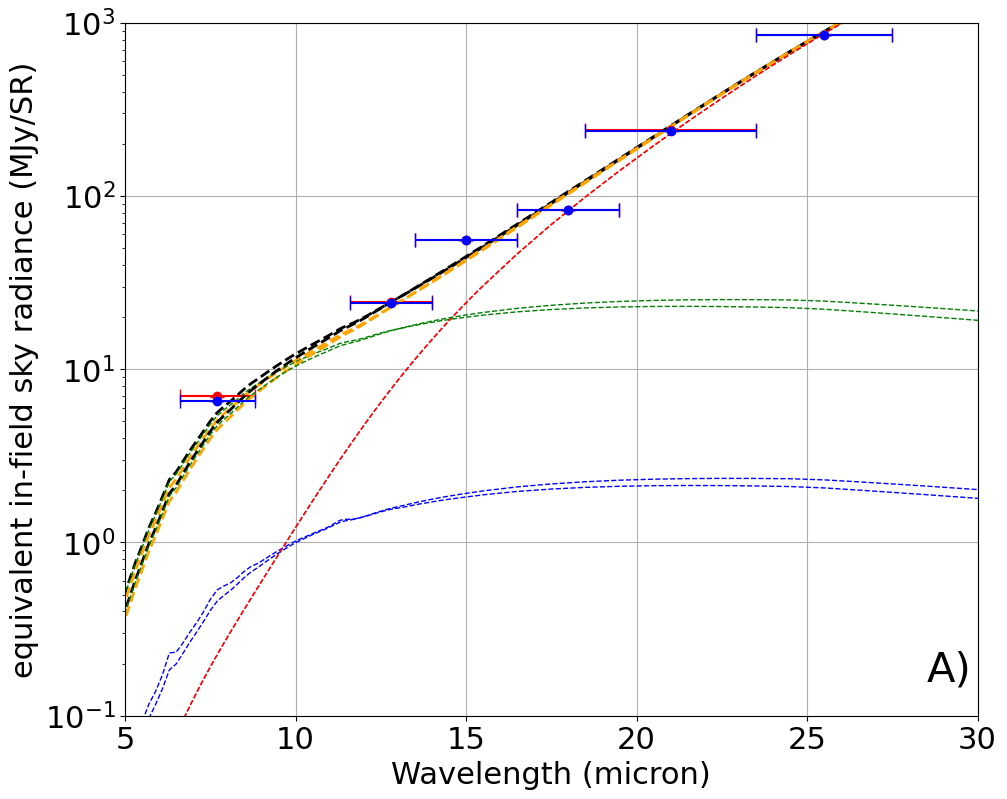

In [351]:
plt.rcParams['figure.figsize'] = (11, 9)
colors = {'245.0432_29.5309_doy133' : 'b', '271.4996_61.0082_doy131': 'r'}
# Text from Erin:  DOY133 is COLD           DOY131 is HOT

ax = df2.plot(x='wave', y='sb_mjsr_scaled', kind='scatter', color='pink', s=0)
for thisobs in really_unique_obs :
    jrr.jwst.plot_expected_bkgs(bkg_df[thisobs], plotlegend=False, plot_not_thermal=True, plotthermal=True)
    df = grouped[thisobs]
    fmt = colors[thisobs] + 'o'
    plt.errorbar(df.wave, df.sb_mjsr_scaled, xerr=df['filtwidth']/2, yerr=df.sb_mjsr_scaled_std/2, fmt=fmt, lw=1.5, capsize=5)
#
plt.xlim(5, 30)
plt.ylim(0.1,1000)
plt.yscale('log')
plt.annotate("A)", (0.94,0.05), xycoords="axes fraction", fontsize=30)
plt.xlabel('wavelength (micron)')
plt.ylabel("equivalent background (MJy/sr)")
#plt.title("Temp title: prelaunch bkg model including astro bkgs")
pretty_up_the_plot(legendfont='10')
ax.get_legend().remove()
pp.savefig(bbox_inches='tight')

In [352]:
# For a dataframe of observed values df_obs, interpolated the predicted backgrounds, and subtract all but thermal
def subtract_nonthermal_bkg(df_obs, df_pred):  
    df_obs['astro_bkg_subtracted'] = 0.0
    foo = []
    for index, row in df_obs.iterrows():
        predicted = jrr.jwst.interpolate_bkg_try2(df_pred, row.wave)
        bkg_subtracted = row.sb_mjsr_scaled - predicted['zody'] - predicted['Gal'] - predicted['straylight']
        df_obs.at[index, 'astro_bkg_subtracted'] = bkg_subtracted
        foo.append(predicted)
        interpolated_bkgs = pandas.DataFrame.from_dict(foo).sort_values(by='wave')
    return(interpolated_bkgs)  # for reference.  Actually acts on dataframe df_obs

# Sutract all the backgrounds
for thisobs in really_unique_obs :
    foo2 = subtract_nonthermal_bkg(grouped[thisobs], bkg_df[thisobs])
print(foo2)

grouped[thisobs].sort_values(by='wave').head(10)

   wave      total      zody      Gal  straylight   thermal  scaledstraylight
5   7.7    4.92970   3.99750  0.25030     0.45750    0.2243           0.45750
0  12.8   24.36325  14.95460  0.14820     1.57445    7.6860           1.57445
1  15.0   44.72445  18.55620  0.07845     1.91980   24.1700           1.91980
2  18.0  107.28190  21.43705  0.09555     2.20930   83.5400           2.20930
3  21.0  256.80055  22.61395  0.10885     2.32775  231.7500           2.32775
4  25.5  890.42770  22.29950  0.13040     2.29780  865.7000           2.29780


,detector,filtername,unique_tag,wave,filtwidth,x,y,median,median_clipped,observtn,visit,maca_scale,sb_mjsr_scaled,sb_mjsr_scaled_std,shortdet,astro_bkg_subtracted
5,MIRIMAGE,F770W,245.0432_29.5309_doy133,7.7,2.2,1024.0,1032.0,6.526079,6.522340,4.0,1.0,1.000,6.526079,0.003568,MIRI,1.820779
0,MIRIMAGE,F1280W,245.0432_29.5309_doy133,12.8,2.4,1024.0,1032.0,36.105352,36.102428,5.0,1.0,1.494,24.166903,0.030603,MIRI,7.489653
1,MIRIMAGE,F1500W,245.0432_29.5309_doy133,15.0,3.0,1024.0,1032.0,61.155914,61.152943,4.0,1.0,1.095,55.850150,0.076647,MIRI,35.295700
2,MIRIMAGE,F1800W,245.0432_29.5309_doy133,18.0,3.0,1024.0,1032.0,91.329124,91.307743,5.0,1.5,1.100,83.026477,0.030825,MIRI,59.284577
3,MIRIMAGE,F2100W,245.0432_29.5309_doy133,21.0,5.0,1024.0,1032.0,237.628204,237.622162,6.0,1.0,1.000,237.628204,0.004445,MIRI,212.577654
4,MIRIMAGE,F2550W,245.0432_29.5309_doy133,25.5,4.0,1024.0,1032.0,847.030273,847.022766,6.0,1.0,1.000,847.030273,0.507968,MIRI,822.302573


Had to check whether JBT was using v1.1 or 2.2 of the thermal csv file.  Shit, it was using 1.1.  Hacked jbt.py to point to v2.2.  Need to update the ticket


/var/folders/q3/cbbs5gqs1h1_vqmcs5j4bvrrmz2qhx/T/ipykernel_82552/4126615388.py:19: RuntimeWarning: overflow encountered in exp
  return((2.0*h / c**2) * (c*1E4/wave)**3 / (np.exp(h *(c*1E4/wave) / k / T) - 1.0) * area)


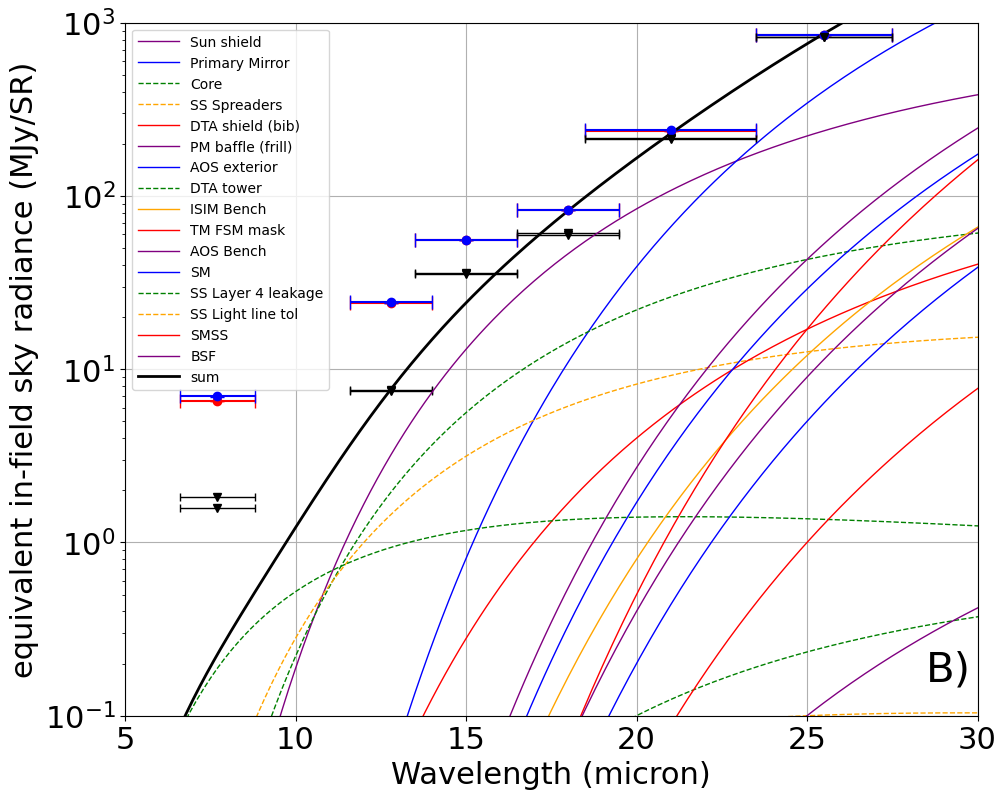

In [353]:
df_bb       = pandas.read_csv('prelaunch_model_params.csv', index_col=0)  # Grab the subcomponents.  None of it is ITAR
plt.rcParams['figure.figsize'] = (11, 9)
ax = df2.plot(x='wave', y='sb_mjsr_scaled', kind='scatter', color='pink', s=10) 
    
for thisobs in really_unique_obs :
    fmt = colors[thisobs] + 'o'
    plt.errorbar(df.wave, df['sb_mjsr_scaled'], xerr=df['filtwidth']/2, yerr=df.sb_mjsr_scaled_std/2, fmt=fmt, lw=1.5, capsize=5)
    df = grouped[thisobs]
    plt.errorbar(df.wave, df['astro_bkg_subtracted'], xerr=df.filtwidth/2, fmt='vk', lw=1, capsize=3)

    
total_allwavcombo = {}
plt.rc('axes', prop_cycle=(cycler('color', mycol2) * cycler('linestyle', '-')))
SS_list =('Sun shield', 'SS Spreaders', 'SS Layer 4 leakage', 'SS Light line tol')
PM_list =('Primary Mirror', 'PM baffle (frill)')
total = np.zeros_like(wave) ; total_PM = np.zeros_like(wave) ; total_SS = np.zeros_like(wave)
for index, row in df_bb.iterrows(): 
    curve = BB_fnu(wave, row['bestT'], row['bestA'])
    linestyle = row.linestyle
    #plot_sub_predictions(wav, row)
    plt.plot(wave, curve, label=row['component'], linestyle=linestyle)
    total += curve
    if row['component'] in SS_list :  total_SS += curve
    if row['component'] in PM_list :  total_PM += curve
total_allwavcombo['curvefit'] = total  # save it for later comparison plotting
plt.plot(wave, total, color='black', label='sum', lw=2, linestyle='-')
pretty_up_the_plot(legendfont='10')
plt.annotate("B)", (0.94,0.05), xycoords="axes fraction", fontsize=30)
#plt.title("Prelaunch thermal model with subcomponents", fontsize=18)
pp.savefig(bbox_inches='tight')
# Note, the non-converged curvefits are plotted as dashed lines.  Converged curvefit=solid

/var/folders/q3/cbbs5gqs1h1_vqmcs5j4bvrrmz2qhx/T/ipykernel_82552/4126615388.py:19: RuntimeWarning: overflow encountered in exp
  return((2.0*h / c**2) * (c*1E4/wave)**3 / (np.exp(h *(c*1E4/wave) / k / T) - 1.0) * area)


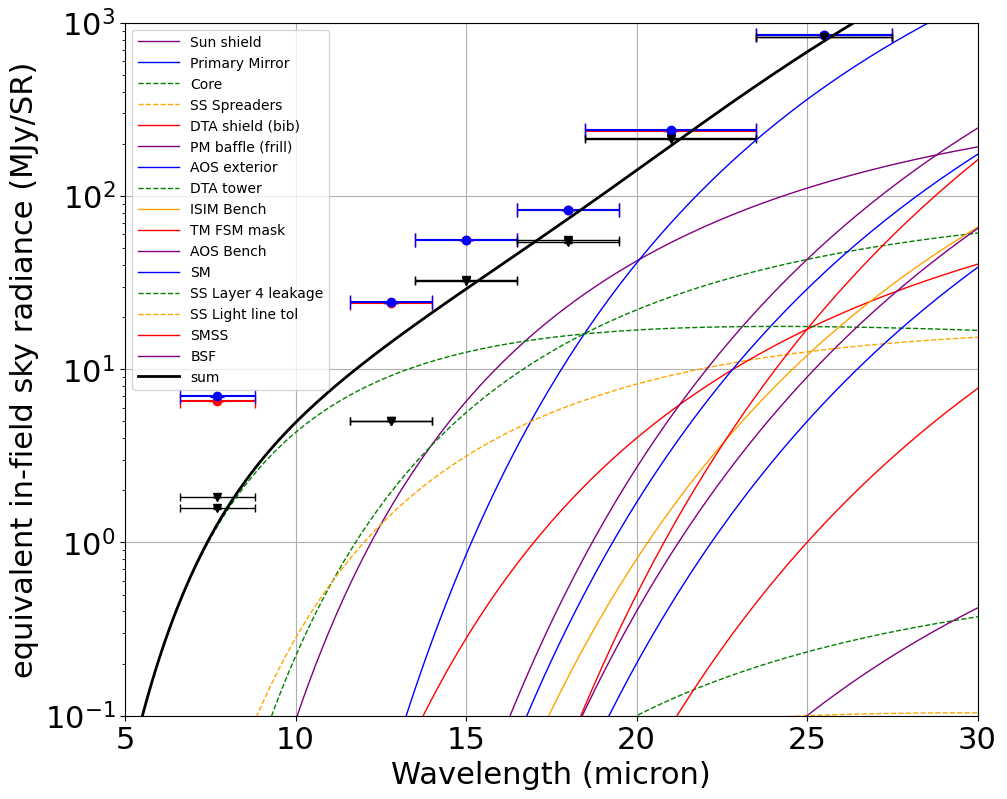

In [354]:
df_bb_juked = pandas.read_csv('prelaunch_model_params_juked.csv', index_col=0, comment='#')  # JRR's hand-hacked version!
plt.rcParams['figure.figsize'] = (11, 9)
ax = df2.plot(x='wave', y='sb_mjsr_scaled', kind='scatter', color='pink', s=0)  # Pink dots are before zodi/ISM subtraction

for thisobs in really_unique_obs :
    fmt = colors[thisobs] + 'o'
    plt.errorbar(df.wave, df['sb_mjsr_scaled'], xerr=df['filtwidth']/2, yerr=df.sb_mjsr_scaled_std/2, fmt=fmt, lw=1.5, capsize=5)
    df = grouped[thisobs]
    #plt.errorbar(df.wave, df['astro_bkg_subtracted'], xerr=df.filtwidth/2, yerr=df.median_std/2, fmt='ko', lw=1, capsize=3)
    plt.errorbar(df.wave, df['astro_bkg_subtracted']/df['maca_scale'], xerr=df.filtwidth/2, yerr=df.sb_mjsr_scaled_std/2, fmt='vk', lw=1, capsize=3)

total_allwavcombo = {}
plt.rc('axes', prop_cycle=(cycler('color', mycol2) * cycler('linestyle', '-')))
SS_list =('Sun shield', 'SS Spreaders', 'SS Layer 4 leakage', 'SS Light line tol')
PM_list =('Primary Mirror', 'PM baffle (frill)')
total = np.zeros_like(wave) ; total_PM = np.zeros_like(wave) ; 
total_SS = np.zeros_like(wave)  ; total_rest = np.zeros_like(wave)
for index, row in df_bb_juked.iterrows(): 
    curve = BB_fnu(wave, (row['bestT'] + row['dT']), (row['bestA'] * row['scaleby']))
    linestyle = row.linestyle
    #plot_sub_predictions(wav, row)
    plt.plot(wave, curve, label=row['component'], linestyle=linestyle)
    total += curve
    if row['component'] in SS_list :  total_SS += curve
    elif row['component'] in PM_list :  total_PM += curve
    else : total_rest += curve
total_allwavcombo['curvefit'] = total  # save it for later comparison plotting
plt.plot(wave, total, color='black', label='sum', lw=2, linestyle='-')
pretty_up_the_plot(legendfont='10')
#plt.title("Jane's hacked model to fit thermal balance test, PID1052", fontsize=18)
pp.savefig(bbox_inches='tight')
# Note, the non-converged curvefits are plotted as dashed lines.  Converged curvefit=solid

In [355]:
df.to_csv('thermal_data_Sept2022.csv')

In [356]:
# Write the new file
threshold= 1E-10
total[total < threshold] = 0.0
outfile = outdir + "thermal_curve_jwst_jrigby_v" + vv + ".csv"
np.savetxt(outfile, np.transpose([wave, total]), "%.3E,%.3E", header=head)

In [357]:
bol_file = '/Users/jrrigby1/SCIENCE/JWST_Data/Prelaunch_JWST_Backgrounds/MIRI_bkgs/Outputs_Dec2019_BOL/thermal_curve_jwst_jrigby_v2.0_BOL.csv'
df_bol = pandas.read_csv(bol_file, comment='#', names=('wave', 'fnu_bkg'))
df_bol.head()

,wave,fnu_bkg
0,5.0,0.000034
1,5.1,0.000047
2,5.2,0.000064
3,5.3,0.000087
4,5.4,0.000118


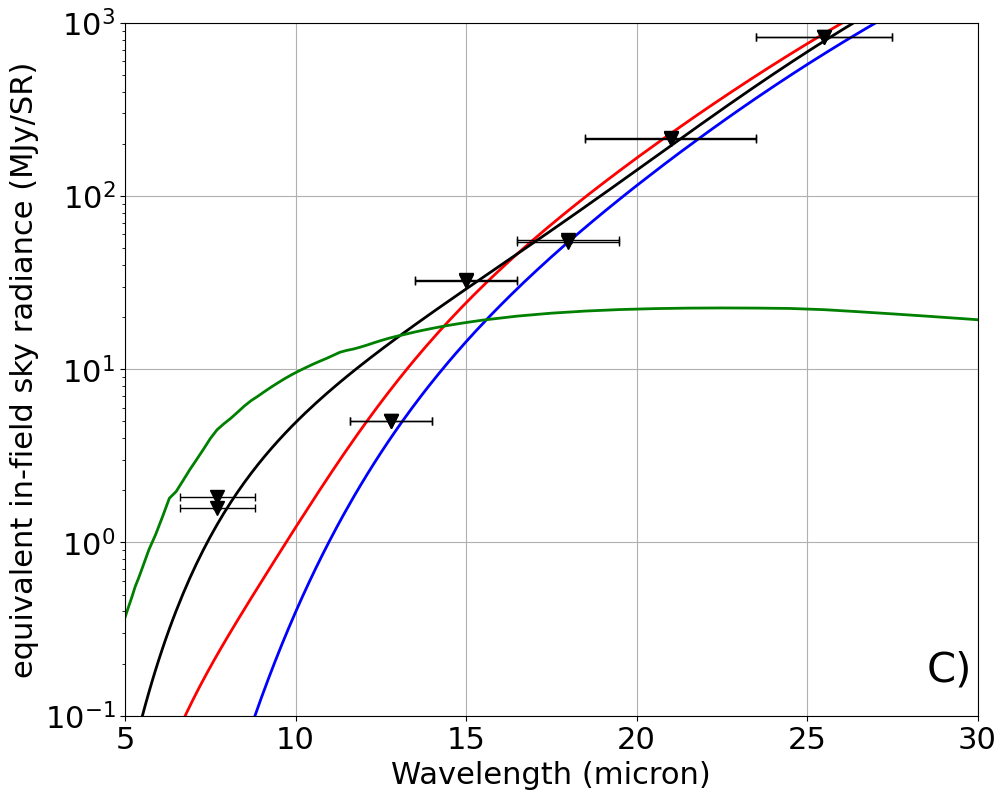

In [358]:
# Compare new and old
plt.plot(df_bkg.wave, df_bkg.fnu_bkg, label='Prelaunch, v2.2 End of Life', color='red', lw=2)
plt.plot(df_bol.wave, df_bol.fnu_bkg, label='Prelaunch, v2.0 Beginning of Life', color='blue', lw=2)

plt.plot(wave, total, label='Post-commissioning, v3.0', color='k', lw=2)
plt.plot(bkg_12minzody.wave, bkg_12minzody.zody + bkg_12minzody.Gal, label='Zodi+ISM at 1.2 min zodi benchmark pointing', color='green', lw=2)
for thisobs in really_unique_obs :
    df = grouped[thisobs]
    plt.errorbar(df.wave, df['astro_bkg_subtracted']/df['maca_scale'], xerr=df.filtwidth/2, yerr=df.sb_mjsr_scaled_std/2, fmt='vk', lw=1, capsize=3, ms=10)
    
pretty_up_the_plot(legendfont=14, legend=False)
plt.annotate("C)", (0.94,0.05), xycoords="axes fraction", fontsize=30)
pp.savefig(bbox_inches='tight')
# Should add requirements!

In [359]:
bkg_12minzody.head()

,wave,total,zody,Gal,straylight,thermal
0,0.5,0.1567,0.1285,0.0040,0.0242,0.0
1,0.6,0.2221,0.1699,0.0057,0.0466,0.0
2,0.7,0.2466,0.1907,0.0067,0.0492,0.0
3,0.8,0.2563,0.1968,0.0078,0.0516,0.0
4,0.9,0.2542,0.1933,0.0082,0.0526,0.0


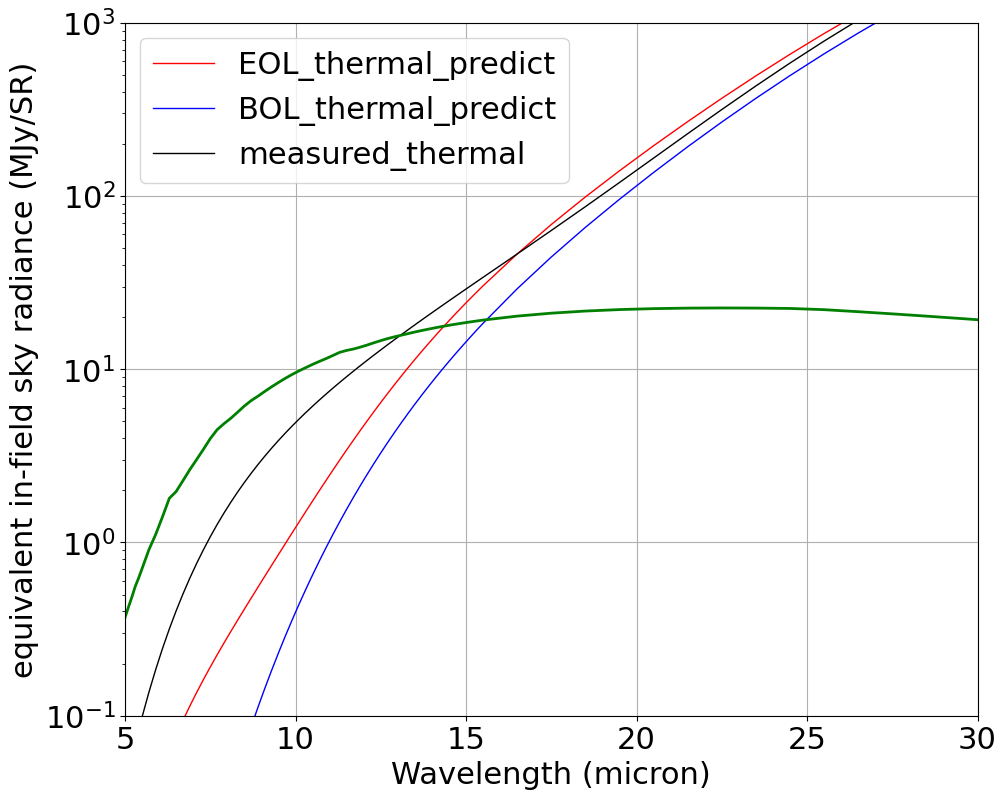

In [360]:
bkg_12minzody['EOL_thermal_predict'] = jrr.spec.rebin_spec_new(df_bkg.wave, df_bkg.fnu_bkg, bkg_12minzody.wave)
bkg_12minzody['BOL_thermal_predict'] = jrr.spec.rebin_spec_new(df_bol.wave, df_bol.fnu_bkg, bkg_12minzody.wave)
bkg_12minzody['measured_thermal'] = jrr.spec.rebin_spec_new(wave,         total, bkg_12minzody.wave)
bkg_12minzody['astro'] = bkg_12minzody.zody + bkg_12minzody.Gal + bkg_12minzody.straylight
bkg_12minzody['tot_EOL'] = bkg_12minzody.astro + bkg_12minzody.EOL_thermal_predict
bkg_12minzody['tot_BOL'] = bkg_12minzody.astro + bkg_12minzody.BOL_thermal_predict
bkg_12minzody['tot_meas'] = bkg_12minzody.astro + bkg_12minzody.measured_thermal
bkg_12minzody.tail()
ax = bkg_12minzody.plot(x='wave', y='EOL_thermal_predict', color='red')
bkg_12minzody.plot(x='wave', y='BOL_thermal_predict', ax=ax, color='blue')
bkg_12minzody.plot(x='wave', y='measured_thermal', ax=ax, color='k')
plt.plot(bkg_12minzody.wave, bkg_12minzody.zody + bkg_12minzody.Gal, label='Zodi+ISM at 1.2 min zodi benchmark pointing', color='g', lw=2)
pretty_up_the_plot(legendfont=14, legend=False)
pp.savefig(bbox_inches='tight')

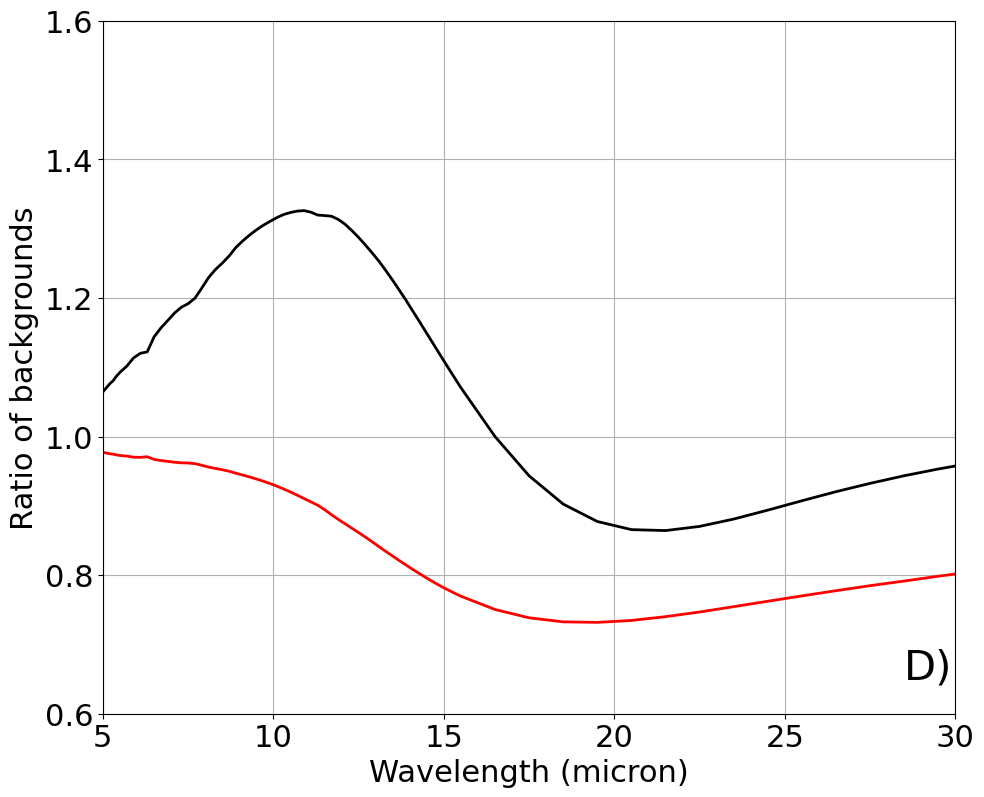

In [361]:
df = bkg_12minzody
plt.plot(df.wave, df.tot_meas / df.tot_EOL, label='Ratio of backgrounds, measured on-orbit to end-of-life prediction', lw=2, color='k')
plt.plot(df.wave, df.tot_BOL / df.tot_EOL, label='Ratio of predicted backgrounds, beginning-of-life to end-of-life', lw=2, color='r')
pretty_up_the_plot(legendfont=16, legend=False)
plt.yscale('linear')
plt.ylim(0.6,1.6)
plt.ylabel("Ratio of backgrounds")
plt.annotate("D)", (0.94,0.05), xycoords="axes fraction", fontsize=30)
pp.savefig(bbox_inches='tight')

In [362]:
df.head(3)

,wave,total,zody,Gal,straylight,thermal,EOL_thermal_predict,BOL_thermal_predict,measured_thermal,astro,tot_EOL,tot_BOL,tot_meas
0,0.5,0.1567,0.1285,0.0040,0.0242,0.0,5.502000e-47,NaN,0.0,0.1567,0.1567,NaN,0.1567
1,0.6,0.2221,0.1699,0.0057,0.0466,0.0,1.792000e-38,NaN,0.0,0.2222,0.2222,NaN,0.2222
2,0.7,0.2466,0.1907,0.0067,0.0492,0.0,2.009000e-32,NaN,0.0,0.2466,0.2466,NaN,0.2466


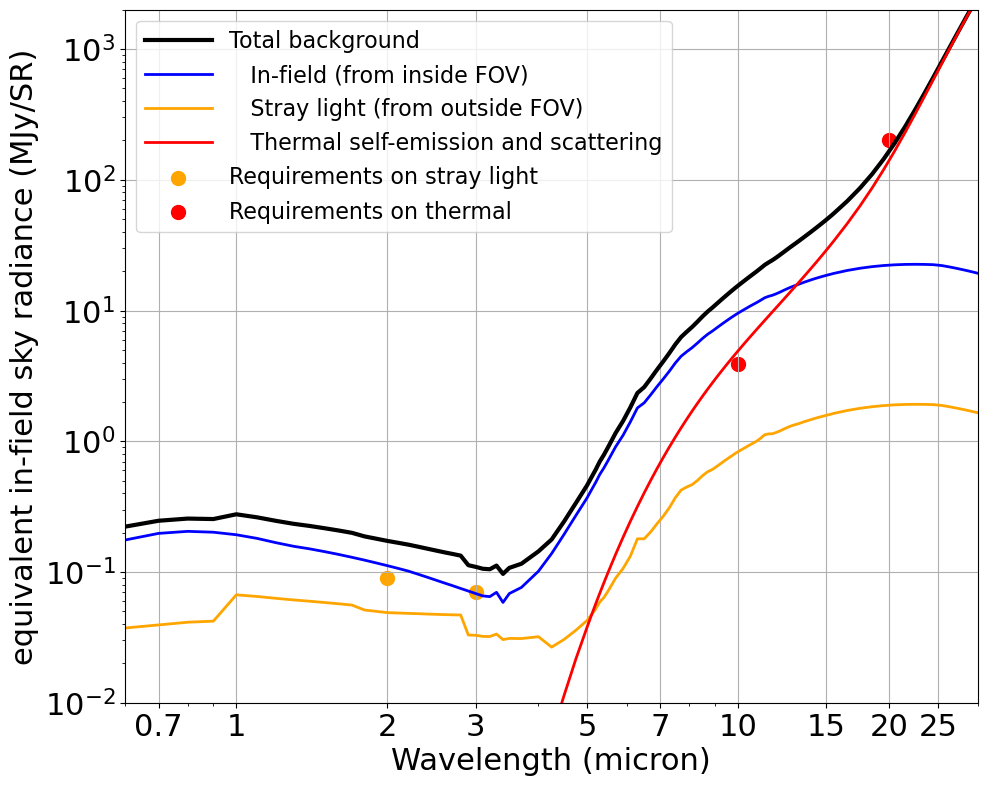

In [363]:
# Revise figure 1 for JDox article on backgrounds
ax = df.plot(x='wave', y='tot_meas', label='Total background', color='k', lw=3)
plt.plot(df.wave, df.zody + df.Gal, label='   In-field (from inside FOV)', color='b', lw=2)
plt.plot(df.wave, df.straylight * 0.8, label='   Stray light (from outside FOV)', color='orange', lw=2)
plt.plot(df.wave, df.measured_thermal, label='   Thermal self-emission and scattering', color='r', lw=2)
plt.scatter((2., 3.), (0.09, 0.07), s=100, label="Requirements on stray light", color="orange")
plt.scatter((10., 20.), (3.9, 200), s=100, label="Requirements on thermal", color="red")
pretty_up_the_plot(legendfont=16)
plt.xscale('log')
plt.xlim(0.6, 30)
plt.ylim(1E-2,2E3)
label_x = (0.7,1,2,3,5,7,10,15,20,25)
foo = plt.xticks(label_x, label_x)
pp.savefig(bbox_inches='tight')
plt.savefig('jdox1.png')

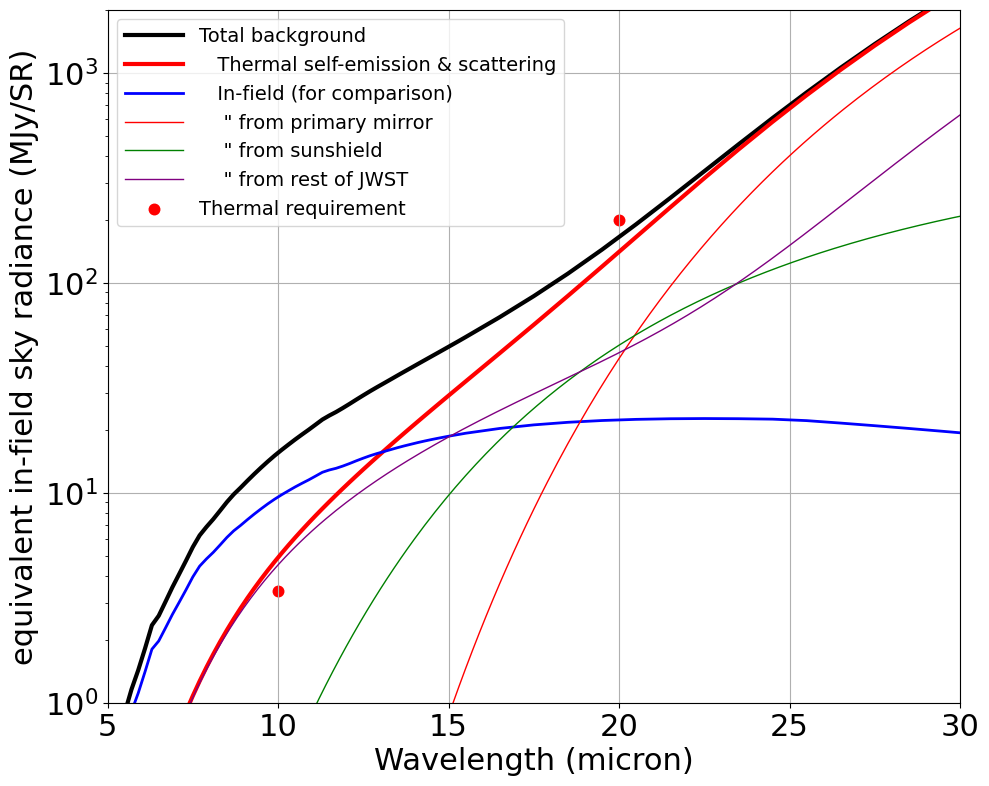

In [364]:
# Revise figure 2 for JDox article on backgrounds
ax = df.plot(x='wave', y='tot_meas', label='Total background', color='k', lw=3)
plt.plot(df.wave, df.measured_thermal, label='   Thermal self-emission & scattering', color='r', lw=3)
plt.plot(df.wave, df.zody + df.Gal, label='   In-field (for comparison)', color='b', lw=2)
allothercomps = total_allwavcombo['curvefit'].copy()  # set it to the full amount, then subtract
plt.plot(wave, total_PM, label="    \" from primary mirror", color='red', linestyle='solid')
plt.plot(wave, total_SS, label="    \" from sunshield", color='green', linestyle='solid')
plt.plot(wave, total_rest, label="    \" from rest of JWST", color='purple', linestyle='solid')
#plt.plot(stsci_df['wavelength'], stsci_df['thermal'], color='black', linestyle='dashed', label='In ETC', lw=2)
plot_Lightsey()
pretty_up_the_plot(legendfont='14')
plt.ylim(1,2000)
pp.savefig(bbox_inches='tight')
plt.savefig('jdox2.png')

In [365]:
pp.close()